# Noise Removal Autoencoder

__Autoencoder__ also helps us to understand how the neural networks work. We can visualize what a node has been experted on. This will give us an intuitive about the way these networks perform.

We will implement an autoencoder that takes  images and tries to reconstruct the image. Then we will visualize the activation of the nodes in the hidden layer. Formula to calculate the activate of node i ($a_{i}$) in the hidden layer with $100$ nodes is:

$a_{i} = f(\sum_{j=1}^{100}W_{ij}^{(1)} + b_{i}^{1})$

## Imports:
We will start with importing the needed libraries for our code.

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Input data:
For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning. One other reason that we use the MNIST is that it is easily accesible through Tensorflow. If you want to know more about the MNIST dataset you can check Yann Lecun's website.
We can easily import the dataset and see the size of training, test and validation set:

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## Hyper-parameters:
Hyper-parameters are important parameters which are not learned by the network. So, we have to specify them externally. These parameters are constant and they are not learnable.

In [3]:
# hyper-parameters
logs_path = "./logs/"  # path to the folder that we want to save the logs for Tensorboard
learning_rate = 0.001  # The optimization learning rate
epochs = 10  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results

# Network Parameters
# We know that MNIST images are 28 pixels in each dimension.
img_h = img_w = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_h * img_w

# number of units in the hidden layer
h1 = 100

##  Graph:
Like before, we start by constructing the graph. But, we need to define some functions that we need rapidly in our code.

In [4]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)


def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(name, shape=[in_dim, num_units])
        tf.summary.histogram('W', W)
        b = bias_variable(name, [num_units])
        tf.summary.histogram('b', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer, W


Now that we have our helper functions we can create our graph.

We we create an __Autoencoder__ with one hidden layer. 

In [5]:
# Create graph
# Placeholders for inputs (x), outputs(y)
with tf.variable_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')

fc1, W1 = fc_layer(x, h1, 'Hidden_layer', use_relu=True)
out, W2 = fc_layer(fc1, img_size_flat, 'Output_layer', use_relu=False)

# calculate the activation 
h_active = W1 / tf.sqrt(tf.reduce_sum(tf.square(W1), axis=0)) # [784, 100]

# Define the loss function, optimizer, and accuracy
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.losses.mean_squared_error(x, out), name='loss')
        tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)

# Initializing the variables
init = tf.global_variables_initializer()
merged = tf.summary.merge_all()

## Train:
As soon as the graph is created, we can run it on a session.

A ```tf.Session()``` is as good as it's runtime. As soon as the cell is run, the session will be ended and we will loose all the information. So. we will define an _InteractiveSession_ to keep the parameters for testing.

To write all the summaries on _logs_ folder for Tensorboard.

In [6]:
# Launch the graph (session)
sess = tf.InteractiveSession() # using InteractiveSession instead of Session to test network in separate cell
sess.run(init)
train_writer = tf.summary.FileWriter(logs_path, sess.graph)
num_tr_iter = int(mnist.train.num_examples / batch_size)
global_step = 0
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    for iteration in range(num_tr_iter):
        batch_x, _ = mnist.train.next_batch(batch_size)

        global_step += 1
        # Run optimization op (backprop)
        feed_dict_batch = {x: batch_x}
        _, summary_tr = sess.run([optimizer, merged], feed_dict=feed_dict_batch)
        train_writer.add_summary(summary_tr, global_step)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch = sess.run(loss,
                                  feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Reconstruction loss={1:.3f}".
                  format(iteration, loss_batch))

    # Run validation after every epoch
    x_valid = mnist.validation.images
    
    feed_dict_valid = {x: x_valid}
    loss_valid = sess.run(loss, feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.3f}".
          format(epoch + 1, loss_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Reconstruction loss=0.114
iter 100:	 Reconstruction loss=0.036
iter 200:	 Reconstruction loss=0.022
iter 300:	 Reconstruction loss=0.017
iter 400:	 Reconstruction loss=0.014
iter 500:	 Reconstruction loss=0.012
---------------------------------------------------------
Epoch: 1, validation loss: 0.011
---------------------------------------------------------
Training epoch: 2
iter   0:	 Reconstruction loss=0.012
iter 100:	 Reconstruction loss=0.010
iter 200:	 Reconstruction loss=0.009
iter 300:	 Reconstruction loss=0.010
iter 400:	 Reconstruction loss=0.009
iter 500:	 Reconstruction loss=0.009
---------------------------------------------------------
Epoch: 2, validation loss: 0.009
---------------------------------------------------------
Training epoch: 3
iter   0:	 Reconstruction loss=0.009
iter 100:	 Reconstruction loss=0.009
iter 200:	 Reconstruction loss=0.009
iter 300:	 Reconstruction loss=0.008
iter 400:	 Reconstruction loss=0.008
iter 500:	 Reconstr

## Test:
Now that the model is trained. It is time to test our model.

We will define some helper functions to visualize the activation of the hidden units.

In [7]:
def plot_max_active(x):
    """
    Plots the images that are maximally activating the hidden units
    :param x: numpy array of size [input_dim, num_hidden_units]
    """
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(17, 17))
    fig.subplots_adjust(hspace=.1, wspace=0)
    img_h = img_w = np.sqrt(x.shape[0]).astype(int)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(x[:, i].reshape((img_h, img_w)), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()

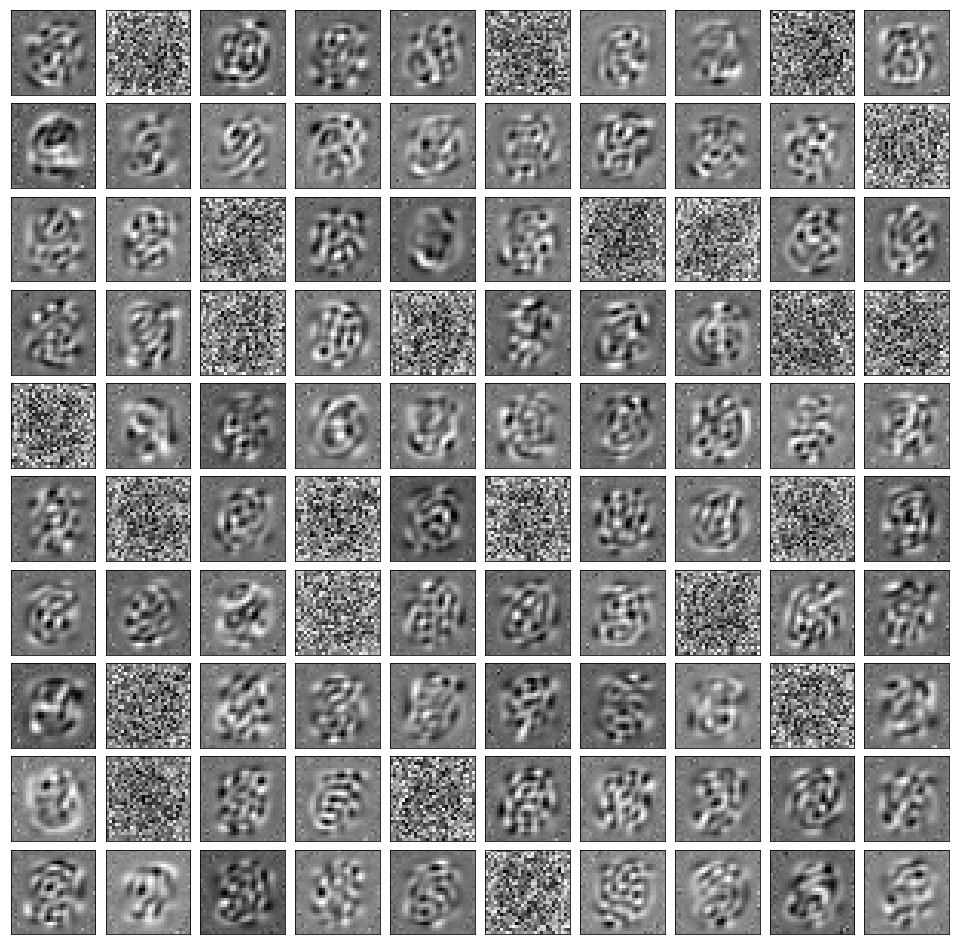

In [8]:
 plot_max_active(sess.run(h_active))

After we are finished the testing, we will close the session to free the memory.

In [9]:
# close the session after you are done with testing
sess.close()

At this step our coding is done. We can inspect more in our network using the __Tensorboard__ open your terminal and type:
```bash
tensorboard --logdir=logs --host localhost
```
__NOTE:__ Don't forget to activate your environment !!!

Open the generated link in your browser.

Thanks for reading! If you have any question or doubt, feel free to leave a comment in our [website](http://easy-tensorflow.com/).